Deeper investigation of statistics of spiking

In [1]:
from pathlib import Path
import os
import pickle
import sys
import importlib
from parse import *

import pandas as pd
from scipy import interpolate, signal, stats, optimize, ndimage
import scipy.io as scio
import numpy as np
import skimage.io as skio
from skimage import measure
from sklearn import neighbors
import lmfit

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cmaps
from matplotlib import gridspec, colors, patches, lines
import colorcet as cc
from cycler import cycler
import seaborn as sns

sys.path.append(os.getenv("SPIKECOUNTER_PATH"))
from spikecounter.analysis import traces, images, loaders
from spikecounter import utils
from spikecounter.ui import visualize
from spikecounter.analysis import stats as sc_stats

from statannotations.Annotator import Annotator
biopubs_style = Path(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
plt.style.use(biopubs_style)

In [2]:
print(os.getenv("DATA_REMOTE_ROOTDIR"))

/n/cohen_lab/Lab/Labmembers/Bill Jia/Data/


In [4]:
# datadirs = ["/n/holyscratch01/cohen_lab/bjia/20210420_gcamp_widefield", \
#             "/n/holyscratch01/cohen_lab/bjia/20210716_gcamp_widefield", \
#            "/n/holyscratch01/cohen_lab/bjia/20210724_gcamp_widefield"]

rootdir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"),
                       "2022 First Heartbeat_Submitted/Figures/Data/Figure1")
expts = ["20210420_gcamp_widefield", \
         "20210716_gcamp_widefield", "20210724_gcamp_widefield"]
datadirs = [rootdir/d for d in expts]
subfolder = "corrected"
output_data_dir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"),
                       "2022 First Heartbeat_Submitted/Figures/Data/Figure2/timeseries")
os.makedirs(output_data_dir, exist_ok=True)

In [5]:
dFFs = []
offset_times = []
all_peaks = []
ts = []
total_embryos = 0
for datadir in datadirs:
    print(datadir)
    dFF_mat = scio.loadmat(datadir/"dFFs.mat")
    print(dFF_mat.keys())
    print(dFF_mat['rois'])
    offset_times.append(dFF_mat["offset_times"].ravel())
    all_peaks.append(pd.read_csv(datadir/"peaks_data.csv"))
    all_peaks[-1]["embryo"] = all_peaks[-1]["roi"] + total_embryos
    dFFs.append(dFF_mat['dFF'])
    ts.append(dFF_mat['t'].ravel())
    total_embryos += len(dFF_mat['rois'].ravel())
all_peaks_combined = pd.concat(all_peaks, axis=0).set_index("embryo")

/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210420_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[ 0  1  2  3  4  5  6  7  8  9 10 11 12]]
/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210716_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[0 1 2 3 4 5 6 7 8]]
/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/20210724_gcamp_widefield
dict_keys(['__header__', '__version__', '__globals__', 'rois', 'offset_times', 'f_s', 'dFF', 't'])
[[ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17]]


In [6]:
expt_moments = []
for datadir in datadirs:
    expt_moments.append(scio.loadmat(datadir/"all_moments.mat"))

Compare normalized return maps

Text(0, 0.5, '$\\mathrm{ISI_{n+2}/ISI_{n}}$')

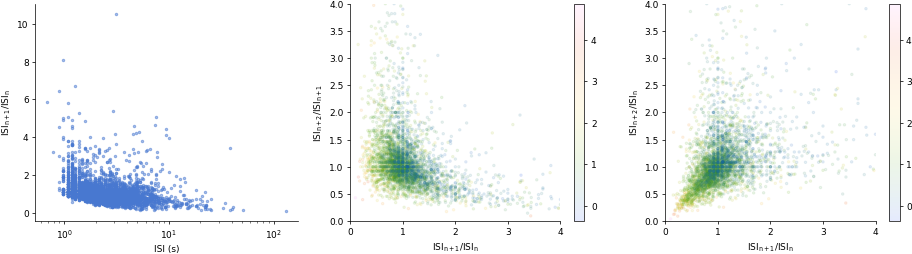

In [26]:
idx = 0
isi_n = all_peaks_combined.loc[idx]["isi"][:-2]
isi_n_shift_1 = all_peaks_combined.loc[idx]["isi"][1:-1]
isi_n_shift_2 = all_peaks_combined.loc[idx]["isi"][2:]

fig1, axes = plt.subplots(1,3,figsize=(16,4))
axes[0].scatter(isi_n, isi_n_shift_1/isi_n, alpha=0.5, s=6)
axes[0].set_xscale("log")
axes[0].set_xlabel("ISI (s)")
axes[0].set_ylabel(r"$\mathrm{ISI_{n+1}/ISI_n}$")

pts = axes[1].scatter(isi_n_shift_1/isi_n, isi_n_shift_2/isi_n_shift_1, alpha=0.1, s=6, c=np.log(isi_n))
plt.colorbar(pts, ax=axes[1])
axes[1].set_xlim(0,4)
axes[1].set_ylim(0,4)

axes[1].set_xlabel(r"$\mathrm{ISI_{n+1}/ISI_{n}}$")
axes[1].set_ylabel(r"$\mathrm{ISI_{n+2}/ISI_{n+1}}$")

pts = axes[2].scatter(isi_n_shift_1/isi_n, isi_n_shift_2/isi_n, alpha=0.1, s=6, c=np.log(isi_n))
plt.colorbar(pts, ax=axes[2])
axes[2].set_xlim(0,4)
axes[2].set_ylim(0,4)

axes[2].set_xlabel(r"$\mathrm{ISI_{n+1}/ISI_{n}}$")
axes[2].set_ylabel(r"$\mathrm{ISI_{n+2}/ISI_{n}}$")
# ax1.set_xscale("log")

### Compute autocorrelations binned by time

In [7]:
all_peaks_combined = pd.read_csv(os.path.join(output_data_dir, "all_peak_timings_combined.csv"), index_col="embryo")

Text(0, 0.5, 'Instantaneous frequency')

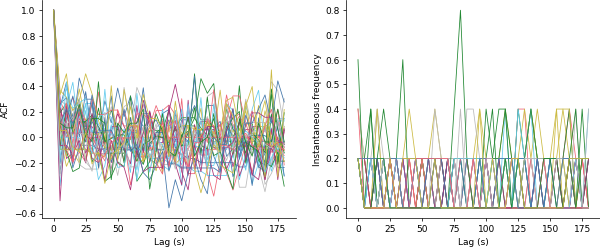

In [8]:
idx = 0
time_bin = 5
window_length = int(180//time_bin)
start_beat = 0
all_acfs_expt = []
mean_freqs = []

fig1, axes = plt.subplots(1,2, figsize=(10,4))

for idx in all_peaks_combined.index.unique():
    i = np.argwhere(all_peaks_combined.loc[idx, "time_rel_offset_s"].to_numpy() > 0).ravel()[0]
    time_rel_beat = all_peaks_combined.loc[idx,"time_rel_offset_s"] - all_peaks_combined.loc[idx,"time_rel_offset_s"].iloc[i]
    time_rel_beat = time_rel_beat[i:]
    n_time_bin = time_rel_beat//time_bin
    freq = n_time_bin.astype(int).value_counts().sort_index()/time_bin
    freq_trace = np.zeros(freq.index.max()+1)
    freq_trace[freq.index] = freq.values
    mean_freqs.append(np.sum(freq_trace[:window_length]/window_length))
    acf = utils.subsampled_autocorrelation(freq_trace, window_length, n_windows=1)
    all_acfs_expt.append(acf)
    axes[0].plot(np.arange(len(acf))*time_bin, acf)
    axes[1].plot(np.arange(len(acf))*time_bin, freq_trace[:window_length+1])

axes[0].set_xlabel("Lag (s)")
axes[0].set_ylabel("ACF")
axes[1].set_xlabel("Lag (s)")
axes[1].set_ylabel("Instantaneous frequency")

In [9]:
all_acfs_expt = np.array(all_acfs_expt)
mean_freq = np.array(mean_freqs)
mean_acf = all_acfs_expt.mean(axis=0)
std_acf = all_acfs_expt.std(axis=0)
lags = np.arange(all_acfs_expt.shape[1])*time_bin

In [139]:
np.savez(os.path.join(output_data_dir, "expt_autocorrelations_time_binned.npz"),
             all_acfs_expt = all_acfs_expt, mean_acf = mean_acf, std_acf = std_acf,
                 lags = lags, mean_freq = mean_freq, time_bin=time_bin)

In [11]:
df = pd.DataFrame(all_acfs_expt.T, columns=[f"embryo_{i}" for i in range(all_acfs_expt.shape[0])])
df["time_lag"] = lags

In [12]:
df.to_csv(output_data_dir/"expt_autocorrelations.csv")

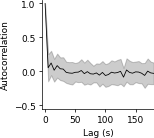

In [101]:
expt_corrs = np.load(output_data_dir/"expt_autocorrelations_time_binned.npz")
with plt.style.context(biopubs_style):
    fig1, ax1 = plt.subplots(figsize=(2,2))
    ax1.plot(expt_corrs["lags"], expt_corrs["mean_acf"], color="k")
    ax1.fill_between(expt_corrs["lags"], expt_corrs["mean_acf"]-expt_corrs["std_acf"], 
                 expt_corrs["mean_acf"]+expt_corrs["std_acf"], color="k", alpha=0.2)
    ax1.set_xlabel("Lag (s)")
    ax1.set_ylabel("Autocorrelation")
    ax1.set_xlim(-5, 180)
    ax1.set_ylim(-0.55, 1.05)
    plt.savefig(output_data_dir/"expt_autocorrelation.svg", dpi=300, bbox_inches="tight")

In [ ]:
freq.

In [71]:
simulation_datadir = "/n/holyscratch01/cohen_lab/bjia/20230306_QIF_repeat_sim/"
qif_fit_params = np.load("/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/QIF_individual_fits_5.npz")
freq_scale_factor = 1/np.median(qif_fit_params["beta_nm"][:,18][:,1])*(1/1.5)
time_bin = 5
window_length = int((180*freq_scale_factor)//time_bin)
all_acfs = []
sigmas = []
lags = []
Is = []
all_isis = []
all_freqs = []

for f in os.listdir(simulation_datadir):
    data_tup = loaders.load_matlab_simulation(simulation_datadir, f)
    if data_tup is None or data_tup[-2] <2:
        continue
    else:
        isis_sim = pd.Series(data_tup[-1])
        
        
        
        spike_positions = np.cumsum(isis_sim)
        n_time_bin = spike_positions//time_bin
        freq = n_time_bin.astype(int).value_counts().sort_index()/time_bin
        freq_trace = np.zeros(freq.index.max()+1)
        freq_trace[freq.index] = freq.values
        acf = signal.correlate(freq_trace[:-window_length]-np.nanmean(freq_trace[:-window_length]),\
                               freq_trace-np.nanmean(freq_trace), mode="valid")
        acf = np.flip(acf)
        acf /= np.max(acf)
        
        all_isis.append(isis_sim)
        all_acfs.extend(acf)
        Is.extend([data_tup[0]]*len(acf))
        sigmas.extend([data_tup[1]]*len(acf))
        lags.extend(list(np.arange(len(acf))*time_bin/freq_scale_factor))
        all_freqs.extend([data_tup[4]]*len(acf))

/tmp/ipykernel_268815/2862111932.py:30: RuntimeWarning: invalid value encountered in true_divide
  acf /= np.max(acf)


In [96]:
acf_datatable = pd.DataFrame(np.array([np.array(sigmas), np.array(Is), np.array(lags), np.array(all_freqs), \
                                          np.array(all_acfs)]).T,\
                              columns=["sigma", "I", "lag", "freq", "corr"])
acf_datatable = acf_datatable.sort_values(["I", "lag"])
acf_datatable = acf_datatable[acf_datatable["sigma"]==1.89]

In [97]:
acf_datatable.to_csv(output_data_dir/"QIF_acf_time_binned.csv")

In [98]:
pv = pd.pivot_table(acf_datatable, index="I", columns="lag", values="corr")

In [99]:
pv = pv.loc[pv.index > -0.1]

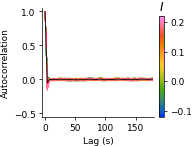

In [100]:
fig1, ax1 = plt.subplots(figsize=(2,2))
cmap = cmaps.get_cmap("cet_CET_R1")

min_I = -0.12
# min_I = 3.7
max_I = 0.22
norm = mpl.colors.Normalize(vmin=min_I, \
                   vmax=max_I)
for idx in pv.index.unique():
    if idx >= min_I and idx <= max_I:
        ax1.plot(pv.columns, pv.loc[idx].to_numpy(), color = cmap(norm(idx)), alpha=0.3)


ax1.set_xlabel("Lag (s)")
ax1.set_ylabel("Autocorrelation")
ax1.set_xlim(-5, 180)
ax1.set_ylim(-0.55, 1.05)
mean_acf = pv.mean(axis=0)
std_acf = pv.std(axis=0)
ax1.plot(pv.columns, mean_acf.to_numpy(), "k")

cax = plt.axes([0.94, 0.125, 0.03, 0.7])
cax.set_title(r"$I$")
cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm, ticks=[-0.1, 0, 0.1, 0.2])

plt.savefig(output_data_dir/"QIF_autocorrelation.svg", dpi=300)

In [108]:
def calculate_sim_acfs(bif, datadir, fit_params_path, prefactor, time_bin=2, window_length_s=180):
    fit_params = np.load(fit_params_path)
    freq_scale_factor = 1/np.median(fit_params["beta_nm"][:,18][:,1])*prefactor
    all_acfs = []
    sigmas = []
    lags = []
    Is = []
    freqs = []
    window_length = int((window_length_s*freq_scale_factor)//time_bin)
    print(window_length)

    for f in os.listdir(datadir):
        data_tup = loaders.load_python_simulation(datadir, f, \
                            parse_string="%s_sigma_{sigma:f}_I_{I:f}.npz" % bif)
        if data_tup is None:
            print(f)
            continue
        else:
            keys, npz = data_tup
            spike_positions = np.cumsum(pd.Series(npz["all_isis"]))
            if (len(spike_positions) == 0) | (np.max(spike_positions) < (120*freq_scale_factor)):
                continue

            I = npz["I"]
            sigma = npz["sigma"]
            n_time_bin = spike_positions//time_bin
            freq = n_time_bin.astype(int).value_counts().sort_index()/time_bin
            freq_trace = np.zeros(freq.index.max()+1)
            freq_trace[freq.index] = freq.values
            try:
                acf = signal.correlate(freq_trace[:-window_length]-np.nanmean(freq_trace[:-window_length]),\
                                           freq_trace-np.nanmean(freq_trace), mode="valid")
            except ValueError as e:
                print(np.max(spike_positions))
                print(120*freq_scale_factor)
                print(freq_trace)
                raise e
            acf = np.flip(acf)/np.max(acf)
            all_acfs.extend(acf)
            Is.extend([I]*len(acf))
            sigmas.extend([sigma]*len(acf))
            lags.extend(list(np.arange(len(acf))*time_bin/freq_scale_factor))
            freqs.extend([npz["f"]*freq_scale_factor]*len(acf))

    acf_datatable = pd.DataFrame(np.array([np.array(sigmas), np.array(Is), np.array(lags), np.array(freqs), \
                                          np.array(all_acfs)]).T,\
                              columns=["sigma", "I", "lag", "freq", "corr"])
    acf_datatable = acf_datatable.sort_values(["I", "lag"])
    return acf_datatable

def plot_pv(pv, title):
    fig1, ax1 = plt.subplots(figsize=(2,2))
    cmap = cmaps.get_cmap("cet_CET_R1")

    min_I = np.min(pv.index.unique())
    max_I = np.max(pv.index.unique())
    norm = mpl.colors.Normalize(vmin=min_I, \
                       vmax=max_I)
    for idx in pv.index.unique():
        if idx >= min_I and idx <= max_I:
            ax1.plot(pv.columns, pv.loc[idx].to_numpy(), color = cmap(norm(idx)), alpha=0.3)


    ax1.set_xlabel("Lag (s)")
    ax1.set_ylabel("Autocorrelation")
    ax1.set_xlim(-5, 180)
    ax1.set_ylim(-0.55, 1.05)
    mean_acf = pv.mean(axis=0)
    std_acf = pv.std(axis=0)
    ax1.plot(pv.columns, mean_acf.to_numpy(), "k")

    cax = plt.axes([0.94, 0.125, 0.03, 0.7])
    cax.set_title(r"$I$")
    cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm)
    ax1.set_title(title, size=11)
    ax1.set_yticks([0, 0.5, 1])

In [165]:
sn_datadir = "/n/holyscratch01/cohen_lab/bjia/20230316_MorrisLecar_saddle_node_autocorr/"
saddle_node_fit_params = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/saddle_node_individual_fits_randinit3.npz"
prefactor = (1/0.45)
acf_datatable_sn = calculate_sim_acfs("saddle_node", sn_datadir, saddle_node_fit_params, prefactor, time_bin=time_bin)
acf_datatable_sn.to_csv(os.path.join(output_data_dir, "saddle_node_acf_time_binned.csv"))

40


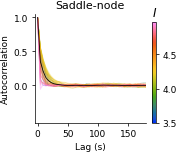

In [113]:
plot_pv(pd.pivot_table(acf_datatable_sn[np.isfinite(acf_datatable_sn["corr"])],
                       index="I", columns="lag", values="corr"), title="Saddle-node")
plt.savefig(output_data_dir/"acf_saddle_node.svg", dpi=300)

In [169]:
snic_ml_datadir = "/n/holyscratch01/cohen_lab/bjia/20230330_MorrisLecar_snic_autocorr/"
snic_fit_params = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/snic_individual_fits_randinit3.npz"
prefactor = 1/0.1
acf_datatable_snic = calculate_sim_acfs("snic", snic_ml_datadir, snic_fit_params, prefactor, time_bin=time_bin)
acf_datatable_snic.to_csv(os.path.join(output_data_dir, "snic_acf_time_binned.csv"))

305


/tmp/ipykernel_242283/3255600857.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf = np.flip(acf)/np.max(acf)


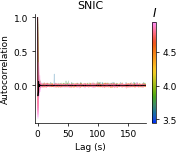

In [112]:
plot_pv(pd.pivot_table(acf_datatable_snic[np.isfinite(acf_datatable_snic["corr"])],
                       index="I", columns="lag", values="corr"), title="SNIC")
plt.savefig(output_data_dir/"acf_snic_ML.svg", dpi=300)

In [171]:
supercritical_ml_datadir = "/n/holyscratch01/cohen_lab/bjia/20230330_MorrisLecar_supercritical_hopf_autocorr/"
supercritical_fit_params = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/supercritical_hopf_individual_fits_randinit3.npz"
prefactor = 1/0.15
acf_datatable_supercritical_hopf = calculate_sim_acfs("supercritical_hopf", supercritical_ml_datadir,
                                                    supercritical_fit_params, prefactor, time_bin=time_bin)
acf_datatable_supercritical_hopf.to_csv(os.path.join(output_data_dir, "supercritical_hopf_acf_time_binned.csv"))

150


/tmp/ipykernel_242283/3255600857.py:38: RuntimeWarning: invalid value encountered in true_divide
  acf = np.flip(acf)/np.max(acf)


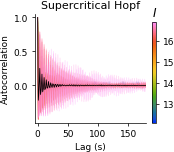

In [111]:
plot_pv(pd.pivot_table(acf_datatable_supercritical_hopf,
                       index="I", columns="lag", values="corr"), title="Supercritical Hopf")
plt.savefig(output_data_dir/"acf_supercritical_hopf.svg", dpi=300)

In [218]:
subcritical_ml_datadir = "/n/holyscratch01/cohen_lab/bjia/20230330_MorrisLecar_subcritical_hopf_autocorr/"
subcritical_fit_params = "/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/subcritical_hopf_individual_fits_randinit3.npz"
prefactor = 1/0.18
acf_datatable_subcritical_hopf = calculate_sim_acfs("subcritical_hopf", subcritical_ml_datadir,
                                                    subcritical_fit_params, prefactor, time_bin=time_bin)
acf_datatable_subcritical_hopf.to_csv(os.path.join(output_data_dir, "subcritical_hopf_acf_time_binned.csv"))

102


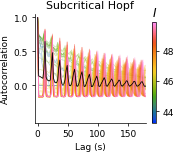

In [110]:
plot_pv(pd.pivot_table(acf_datatable_subcritical_hopf,
                       index="I", columns="lag", values="corr"), title="Subcritical Hopf")
plt.savefig(output_data_dir/"acf_subcritical_hopf.svg", dpi=300)

In [78]:
acf_datatable_sn = pd.read_csv(os.path.join(output_data_dir, "saddle_node_acf_time_binned.csv"))
acf_datatable_snic = pd.read_csv(os.path.join(output_data_dir, "snic_acf_time_binned.csv"))
acf_datatable_supercritical_hopf = pd.read_csv(os.path.join(output_data_dir, "supercritical_hopf_acf_time_binned.csv"))
acf_datatable_subcritical_hopf = pd.read_csv(os.path.join(output_data_dir, "subcritical_hopf_acf_time_binned.csv"))

In [190]:
acf_datatable_snic

,Unnamed: 0,sigma,I,lag,freq,corr
0,7344,20.0,3.40,0.000000,0.000340,NaN
1,7345,20.0,3.40,0.588739,0.000340,NaN
2,7346,20.0,3.40,1.177479,0.000340,NaN
3,7347,20.0,3.40,1.766218,0.000340,NaN
4,7348,20.0,3.40,2.354958,0.000340,NaN
...,...,...,...,...,...,...
9787,8869,20.0,4.95,177.210575,0.556443,0.004010
9788,8870,20.0,4.95,177.799314,0.556443,0.001198
9789,8871,20.0,4.95,178.388053,0.556443,-0.003487
9790,8872,20.0,4.95,178.976793,0.556443,0.004478


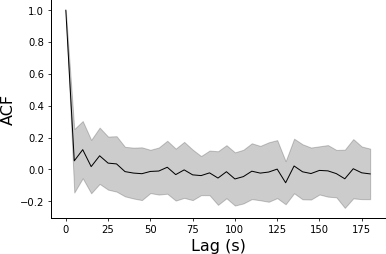

In [176]:
expt_corrs = np.load(os.path.join(output_data_dir, "expt_autocorrelations_time_binned.npz"))
with plt.style.context("../bio_pubs_presentation.mplstyle"):
    fig1, ax1 = plt.subplots(figsize=(6,4))
    ax1.plot(expt_corrs["lags"], expt_corrs["mean_acf"], color="k", label="Experiment")
    ax1.fill_between(expt_corrs["lags"], expt_corrs["mean_acf"]-expt_corrs["std_acf"], 
                 expt_corrs["mean_acf"]+expt_corrs["std_acf"], color="k", alpha=0.2)
    ax1.set_xlabel("Lag (s)")
    ax1.set_ylabel("ACF")
    
#     mean_acf = pv.mean(axis=0)
#     std_acf = pv.std(axis=0)
#     ax1.plot(pv.columns, mean_acf.to_numpy(), color="r", label="Saddle-node")
#     ax1.legend()

In [224]:
datatables_by_bif = {"snic": acf_datatable_snic, 
                     "saddle_node": acf_datatable_sn,
                     "supercritical_hopf": acf_datatable_supercritical_hopf,
                     "subcritical_hopf": acf_datatable_subcritical_hopf}

Text(0, 0.5, 'Lag 2s ACF')

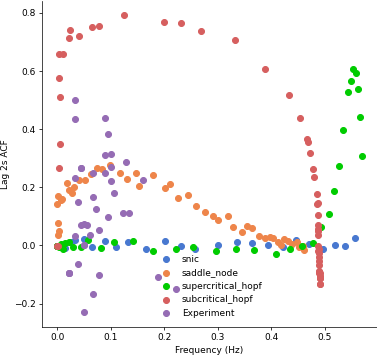

In [226]:
lag_idx = 2
fig1, ax1 = plt.subplots(figsize=(6,6))
for bif, dt in datatables_by_bif.items():
    grouped_acf = dt.groupby("lag")
    unique_lags = list(grouped_acf.indices.keys())
#     print(unique_lags[:10])
    lag_t = unique_lags[np.argwhere(unique_lags>=expt_corrs["time_bin"]*lag_idx).ravel()[0]]
    single_lag_corrs = grouped_acf.get_group(lag_t)
    ax1.scatter(single_lag_corrs["freq"], single_lag_corrs["corr"], label=bif)
ax1.scatter(expt_corrs["mean_freq"], expt_corrs["all_acfs_expt"][:,lag_idx], label="Experiment")
ax1.legend()
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("Lag 2s ACF")

Compare squared error of experimental autocorrelation function to each model using the parameter set with closest mean frequency. Individual traces will have a lot of measurement noise, making a lag[n] autocorrelation comparison unreliable

In [227]:
freq_grouped_acfs_by_bif = dict([(bif, datatables_by_bif[bif].groupby("freq")) for bif in datatables_by_bif])

In [228]:
list(expt_corrs.keys())

['all_acfs_expt', 'mean_acf', 'std_acf', 'lags', 'mean_freq', 'time_bin']

In [229]:
mse_data = []
for idx, expt_acf in enumerate(expt_corrs["all_acfs_expt"]):
    for bif, fg_acf in freq_grouped_acfs_by_bif.items():
        freqs = np.array(list(fg_acf.indices.keys()))
        best_fit_sim = np.argmin(np.abs(expt_corrs["mean_freq"][idx]-freqs))
        sim_acf = fg_acf.get_group(freqs[best_fit_sim])
        interpolated_sim_acf = interpolate.interp1d(sim_acf["lag"], sim_acf["corr"], fill_value="extrapolate")(expt_corrs["lags"])
        mse = np.nanmean((interpolated_sim_acf - expt_acf)**2)
        mse_data.append((idx, best_fit_sim, bif, mse))
mse_data = pd.DataFrame(mse_data, columns=["experiment_id", "sim_id", "bifurcation", "mse"])

In [230]:
mse_data["log_mse"] = np.log(mse_data["mse"])

<AxesSubplot:xlabel='bifurcation', ylabel='log_mse'>

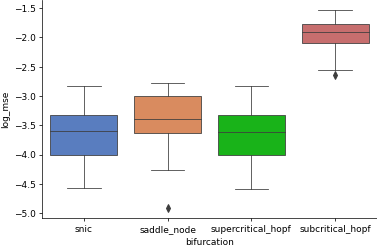

In [231]:
fig1, ax1 = plt.subplots(figsize=(6,4))
sns.boxplot(data=mse_data, x="bifurcation", y="log_mse", ax=ax1)